In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
from LinearKalmanNet import LinearKalmanNet
from KalmanNet2 import KalmanNet2
from KalmanNet import KalmanNet
from utils import generate_data, train
from Kalman import KalmanFilter
from ExtendedKalmanFilter import ExtendedKalmanFilter
from LinearSystem import LinearSystem
from NonLinearSystem import NonlinearSystem
from torch.utils.data import TensorDataset, DataLoader, random_split
from utils import train_with_scheduler


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


# Testcase 1: Lineární systém
Předpoklad, že uvažovaný model systému je identický jako samotný systém. Kromě počátečních podmínek.

In [ ]:
# --- Reálný systém ---
F_true = torch.tensor([[0.5]])
H_true = torch.tensor([[1.0]])
Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])
Ex0_true = torch.tensor([[1.0]])  # Očekávaná hodnota počátečního stavu
P0_true = torch.tensor([[1.2]])  # Počáteční kov

sys_true = LinearSystem(Ex0_true,P0_true,F_true, H_true, Q_true, R_true)

Ex0_model = torch.tensor([[0.5]])  # Očekávaná hodnota počátečního stavu
P0_model = torch.tensor([[1.5]])  # Počáteční kov

F_model = F_true
H_model = H_true
Q_model = Q_true
R_model = R_true
sys_model = LinearSystem(Ex0_model,P0_model,F_model,H_model,Q_model,R_model)


In [ ]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200) # Jedna delší trajektorie pro test


In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
kalman_filter = KalmanFilter(Ex0_model, P0_model, F_model, H_model, Q_model, R_model)
kf_data = kalman_filter.apply_filter(y_test[0])
x_hat_kf = kf_data['x_filtered']

In [ ]:
knet = LinearKalmanNet(sys_model,128).to(device)
train(knet, train_loader,device,epochs=50, lr=1e-4)

In [ ]:
knet.eval()
with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_test_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_test_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_kf = mse_criterion(x_hat_kf, x_test[0])

print(f"\nVýsledná MSE KalmanNet: {mse_knet.item():.4f}")
print(f"Výsledná MSE klasického KF: {mse_kf.item():.4f}")

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Porovnání odhadů: KalmanNet vs. Klasický Kalmanův Filtr", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_kf_plot = x_hat_kf.squeeze().numpy()

plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=4, alpha=0.6, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_kf_plot, 'b--', linewidth=2.5, label=f"Odhad Klasický KF (MSE={mse_kf.item():.4f})")

plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Testcase 2: Nelineární systém
Předpoklad, že uvažovaný model systému je identický jako samotný systém

In [ ]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[1.0]])
sys_model= NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [ ]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [ ]:
ekf = ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']

In [ ]:
knet_nelinearni = KalmanNet(sys_model).to(device)
train(knet_nelinearni, train_loader, device, epochs=50, lr=1e-4)

In [ ]:
print("\n--- Trénování KalmanNet Architektury #2 ---")
knet2 = KalmanNet2(sys_model, in_mult=20, out_mult=30).to(device)
train(knet2, train_loader, device, epochs=50, lr=1e-4)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()

In [ ]:
knet = knet_nelinearni
knet.eval()

with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_ekf = mse_criterion(x_hat_ekf, x_test)
mse_knet2 = mse_criterion(x_hat_knet2, x_test)

print(f"\nVýsledná MSE KalmanNet na nelineárním systému: {mse_knet.item():.4f}")
print(f"Výsledná MSE EKF na nelineárním systému:       {mse_ekf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")

plt.figure(figsize=(16, 8))
plt.title("Porovnání EKF vs. KalmanNet Arch. #1 vs. Arch. #2 (Perfektní model)", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_ekf_plot = x_hat_ekf.numpy()
x_hat_knet2_plot = x_hat_knet2.squeeze().numpy()


plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=5, alpha=0.5, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_ekf_plot, 'b-.', linewidth=2.5, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet2_plot, 'y:', linewidth=2.5, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")


plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# Testcase 3: Nelineární systém s nepřesným modelem

In [ ]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = R_true
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[1.0]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
sys_model = NonlinearSystem(f_model_nonlinear, h_model_nonlinear, Q_model, R_model, Ex0_model, P0_model)

In [ ]:

x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [ ]:
ekf = ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']

In [ ]:
knet_nelinearni = KalmanNet(sys_model).to(device)
train(knet_nelinearni, train_loader, device, epochs=50, lr=1e-4)

In [ ]:
from KalmanNet2 import KalmanNet2
print("\n--- Trénování KalmanNet Architektury #2 ---")
knet2 = KalmanNet2(sys_model, in_mult=20, out_mult=30).to(device)
train(knet2, train_loader, device, epochs=50, lr=1e-4)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()

In [ ]:
knet = knet_nelinearni
knet.eval()

with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_ekf = mse_criterion(x_hat_ekf, x_test)
mse_knet2 = mse_criterion(x_hat_knet2, x_test)

print(f"\nVýsledná MSE KalmanNet na nelineárním systému: {mse_knet.item():.4f}")
print(f"Výsledná MSE EKF na nelineárním systému:       {mse_ekf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")

plt.figure(figsize=(16, 8))
plt.title("Porovnání EKF vs. KalmanNet Arch. #1 vs. Arch. #2 (nepřesný model)", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_ekf_plot = x_hat_ekf.numpy()
x_hat_knet2_plot = x_hat_knet2.squeeze().numpy()


plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=5, alpha=0.5, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_ekf_plot, 'b-.', linewidth=2.5, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet2_plot, 'y:', linewidth=2.5, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")


plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# Testcase 4: Sledování lodi (bez vstupu)

In [ ]:
dt = 0.02

F = torch.tensor([
    [1,0,dt,0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ],dtype=torch.float32
).to(device)

f_true = lambda x: F @ x

def h_true_nonlinear(x):
    x_pos, y_pos = x[0], x[1]
    angle = torch.atan2(y_pos, x_pos)
    distance = torch.sqrt(x_pos**2 + y_pos**2)
    return torch.stack([angle,distance])

Q_true = (torch.eye(4) * 10e-6).to(device)
R_true = torch.tensor([[4e-4*(torch.pi/180)**2, 0], [0, 1e-4]],dtype=torch.float32).to(device)
P0_true = torch.eye(4).to(device)
Ex0_true = torch.tensor([[20, 50, 0,-12]],dtype=torch.float32).T.to(device)

sys_true = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

sys_model = sys_true

In [ ]:
print("\n--- Generování dat pro zjednodušené sledování lodi ---")
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=64, shuffle=True)

In [ ]:
print("\n--- Evaluace EKF ---")
ekf = ExtendedKalmanFilter(sys_model)
ekf_results = ekf.apply_filter(y_test.squeeze(0))
x_hat_ekf = ekf_results['x_filtered']

In [ ]:
print("\n--- Trénování KalmanNet Architektury #1 ---")
# hidden_size_multiplier může být menší, problém je jednodušší
knet1 = KalmanNet(sys_model, device, hidden_size_multiplier=20).to(device)
train(knet1, train_loader, device, epochs=50, lr=1e-4)
knet1.eval()
with torch.no_grad():
    x_hat_knet1 = knet1(y_test.to(device)).cpu()

In [ ]:
print("\n--- Trénování KalmanNet Architektury #2 ---")
# Multiplikátory mohou být menší
knet2 = KalmanNet2(sys_model, in_mult=20, out_mult=30).to(device)
train(knet2, train_loader, device, epochs=40, lr=1e-4)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()

In [ ]:
x_true_pos = x_test.squeeze(0)[:, :2].cpu()
x_hat_ekf_pos = x_hat_ekf[:, :2].cpu()
x_hat_knet1_pos = x_hat_knet1.squeeze(0)[:, :2]
x_hat_knet2_pos = x_hat_knet2.squeeze(0)[:, :2]

mse_ekf = torch.mean(torch.norm(x_hat_ekf_pos - x_true_pos, dim=1)**2)
mse_knet1 = torch.mean(torch.norm(x_hat_knet1_pos - x_true_pos, dim=1)**2)
mse_knet2 = torch.mean(torch.norm(x_hat_knet2_pos - x_true_pos, dim=1)**2)

print("\n--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---")
print(f"Výsledná MSE EKF:                      {mse_ekf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #1):     {mse_knet1.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")

In [ ]:
plt.figure(figsize=(12, 10))
plt.title("Porovnání odhadů trajektorie lodi (zjednodušený model)", fontsize=16)

y_test_seq = y_test.squeeze(0).cpu()
angles = y_test_seq[:, 0].cpu()
distances = y_test_seq[:, 1].cpu()
y_meas_x = distances * torch.cos(angles)
y_meas_y = distances * torch.sin(angles)

plt.plot(x_true_pos[:, 0], x_true_pos[:, 1], 'k-', linewidth=3, label="Skutečná trajektorie")
plt.plot(y_meas_x, y_meas_y, 'r.', markersize=4, alpha=0.4, label="Měření (v Kartéz. souř.)")
plt.plot(x_hat_ekf_pos[:, 0], x_hat_ekf_pos[:, 1], 'b-.', linewidth=2, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet1_pos[:, 0], x_hat_knet1_pos[:, 1], 'g--', linewidth=2, label=f"Odhad KNet #1 (MSE={mse_knet1.item():.4f})")
# plt.plot(x_hat_knet2_pos[:, 0], x_hat_knet2_pos[:, 1], 'm:', linewidth=2, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")

plt.xlabel("Poloha X [m]", fontsize=12)
plt.ylabel("Poloha Y [m]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11)
plt.axis('equal')
plt.show()

# Test adaptivniho LR na sledovani polohy lodi

In [17]:
dt = 0.02

F = torch.tensor([
    [1,0,dt,0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ],dtype=torch.float32
).to(device)

f_true = lambda x: F @ x

def h_true_nonlinear(x):
    x_pos, y_pos = x[0], x[1]
    angle = torch.atan2(y_pos, x_pos)
    distance = torch.sqrt(x_pos**2 + y_pos**2)
    return torch.stack([angle,distance])

Q_true = (torch.eye(4) * 10e-6).to(device)
R_true = torch.tensor([[4e-4*(torch.pi/180)**2, 0], [0, 1e-4]],dtype=torch.float32).to(device)
P0_true = torch.eye(4).to(device)
Ex0_true = torch.tensor([[20, 50, 0,-12]],dtype=torch.float32).T.to(device)

sys_true = NonlinearSystem(f_true, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

sys_model = sys_true

In [18]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

# --- 1. Rozdělení dat na trénovací a validační sadu ---
full_train_dataset = TensorDataset(x_train, y_train)

# Např. 90% pro trénování, 10% pro validaci
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Vytvoření DataLoaderů pro obě sady
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [19]:
print("\n--- Evaluace EKF ---")
ekf = ExtendedKalmanFilter(sys_model)
ekf_results = ekf.apply_filter(y_test.squeeze(0))
x_hat_ekf = ekf_results['x_filtered']


--- Evaluace EKF ---


In [20]:
print("\n--- Trénování KalmanNet Architektury #1 ---")
# hidden_size_multiplier může být menší, problém je jednodušší
knet1 = KalmanNet(sys_model, device, hidden_size_multiplier=10).to(device)
train_with_scheduler(knet1, train_loader, val_loader, device, epochs=200, lr=1e-3)
knet1.eval()
with torch.no_grad():
    x_hat_knet1 = knet1(y_test.to(device)).cpu()


--- Trénování KalmanNet Architektury #1 ---
Zahajuji trénování KalmanNetu s dynamickým LR a Early Stopping...


/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epocha [5/200], Train Loss: 0.278408, Val Loss: 0.209987
Epocha [10/200], Train Loss: 0.152037, Val Loss: 0.298173
Epocha [15/200], Train Loss: 0.087731, Val Loss: 0.146408
Epocha [20/200], Train Loss: 0.094675, Val Loss: 0.120409
Epocha [25/200], Train Loss: 0.067744, Val Loss: 0.077179
Epocha [30/200], Train Loss: 0.060702, Val Loss: 0.062934
Epocha [35/200], Train Loss: 0.059057, Val Loss: 0.062500
Epocha [40/200], Train Loss: 0.074200, Val Loss: 0.087606
Epocha [45/200], Train Loss: 0.059487, Val Loss: 0.054224
Epocha [50/200], Train Loss: 0.060003, Val Loss: 0.089495
Epocha [55/200], Train Loss: 0.050664, Val Loss: 0.063090
Epocha [60/200], Train Loss: 0.064808, Val Loss: 0.051397
Epocha [65/200], Train Loss: 0.067804, Val Loss: 0.049210
Epocha [70/200], Train Loss: 0.052821, Val Loss: 0.077090
Epocha [75/200], Train Loss: 0.040582, Val Loss: 0.041128
Epocha [80/200], Train Loss: 0.045395, Val Loss: 0.047425
Epocha [85/200], Train Loss: 0.040496, Val Loss: 0.040814
Epocha [90/200]

In [21]:
print("\n--- Trénování KalmanNet Architektury #2 ---")
# Multiplikátory mohou být menší
knet2 = KalmanNet2(sys_model, in_mult=20, out_mult=30).to(device)
train_with_scheduler(knet2, train_loader, val_loader, device, epochs=200, lr=1e-3)
knet2.eval()
with torch.no_grad():
    x_hat_knet2 = knet2(y_test.to(device)).cpu()


--- Trénování KalmanNet Architektury #2 ---
Zahajuji trénování KalmanNetu s dynamickým LR a Early Stopping...


/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epocha [5/200], Train Loss: 0.276092, Val Loss: 0.249640
Epocha [10/200], Train Loss: 0.199049, Val Loss: 0.121318
Epocha [15/200], Train Loss: 0.050585, Val Loss: 0.056338
Epocha [20/200], Train Loss: 0.042023, Val Loss: 0.042493
Epocha [25/200], Train Loss: 0.050556, Val Loss: 0.066188
Epocha [30/200], Train Loss: 0.032831, Val Loss: 0.038821
Epocha [35/200], Train Loss: 0.033011, Val Loss: 0.027209
Epocha [40/200], Train Loss: 0.033820, Val Loss: 0.029427
Epocha [45/200], Train Loss: 0.027761, Val Loss: 0.027315
Epocha [50/200], Train Loss: 0.025896, Val Loss: 0.025705
Epocha [55/200], Train Loss: 0.024961, Val Loss: 0.025897
Epocha [60/200], Train Loss: 0.025006, Val Loss: 0.024643
Epocha [65/200], Train Loss: 0.025257, Val Loss: 0.024924
Epocha [70/200], Train Loss: 0.023651, Val Loss: 0.024145
Epocha [75/200], Train Loss: 0.023048, Val Loss: 0.024084
Epocha [80/200], Train Loss: 0.027174, Val Loss: 0.060345
Epocha [85/200], Train Loss: 0.022679, Val Loss: 0.023398
Epocha [90/200]

In [22]:
x_true_pos = x_test.squeeze(0)[:, :2].cpu()
x_hat_ekf_pos = x_hat_ekf[:, :2].cpu()
x_hat_knet1_pos = x_hat_knet1.squeeze(0)[:, :2]
x_hat_knet2_pos = x_hat_knet2.squeeze(0)[:, :2]

mse_ekf = torch.mean(torch.norm(x_hat_ekf_pos - x_true_pos, dim=1)**2)
mse_knet1 = torch.mean(torch.norm(x_hat_knet1_pos - x_true_pos, dim=1)**2)
mse_knet2 = torch.mean(torch.norm(x_hat_knet2_pos - x_true_pos, dim=1)**2)

print("\n--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---")
print(f"Výsledná MSE EKF:                      {mse_ekf.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #1):     {mse_knet1.item():.4f}")
print(f"Výsledná MSE KalmanNet (Arch. #2):     {mse_knet2.item():.4f}")


--- Výsledky porovnání (Zjednodušené sledování, perfektní model) ---
Výsledná MSE EKF:                      0.0001
Výsledná MSE KalmanNet (Arch. #1):     0.0013
Výsledná MSE KalmanNet (Arch. #2):     0.0007


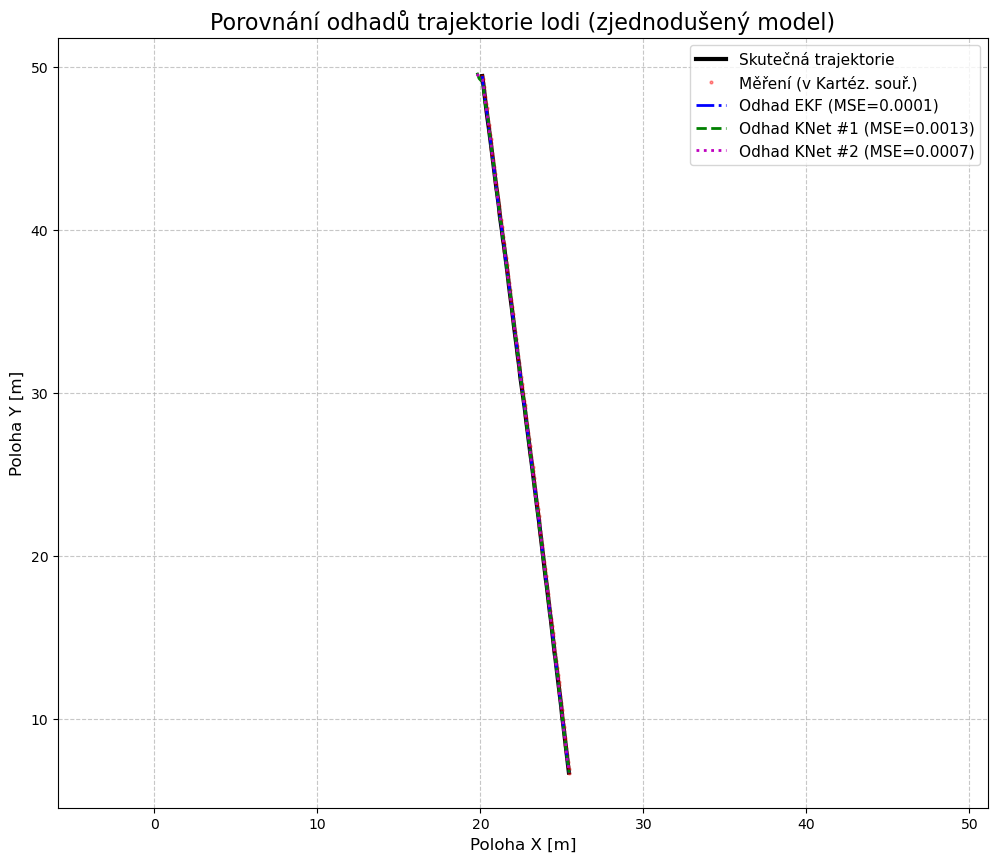

In [23]:
plt.figure(figsize=(12, 10))
plt.title("Porovnání odhadů trajektorie lodi (zjednodušený model)", fontsize=16)

y_test_seq = y_test.squeeze(0).cpu()
angles = y_test_seq[:, 0].cpu()
distances = y_test_seq[:, 1].cpu()
y_meas_x = distances * torch.cos(angles)
y_meas_y = distances * torch.sin(angles)

plt.plot(x_true_pos[:, 0], x_true_pos[:, 1], 'k-', linewidth=3, label="Skutečná trajektorie")
plt.plot(y_meas_x, y_meas_y, 'r.', markersize=4, alpha=0.4, label="Měření (v Kartéz. souř.)")
plt.plot(x_hat_ekf_pos[:, 0], x_hat_ekf_pos[:, 1], 'b-.', linewidth=2, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")
plt.plot(x_hat_knet1_pos[:, 0], x_hat_knet1_pos[:, 1], 'g--', linewidth=2, label=f"Odhad KNet #1 (MSE={mse_knet1.item():.4f})")
plt.plot(x_hat_knet2_pos[:, 0], x_hat_knet2_pos[:, 1], 'm:', linewidth=2, label=f"Odhad KNet #2 (MSE={mse_knet2.item():.4f})")

plt.xlabel("Poloha X [m]", fontsize=12)
plt.ylabel("Poloha Y [m]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11)
plt.axis('equal')
plt.show()